# Height data

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
import pyro.poutine as poutine
from pyro.infer import infer_discrete
from pyro.ops.indexing import Vindex
from scipy.io import savemat
#plt.rc('text', usetex=True)

In [3]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve

from scipy.io import loadmat

In [4]:
heights = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]
pi_z = "15"
lamda_j = "15"

### Results

In [5]:
names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]
# snr = [float(name) for name in names]

In [14]:
D = 14
background = 150
gain = torch.tensor(7.)

rv = dist.MultivariateNormal(
    torch.tensor([6.5, 6.5]),
    scale_tril=torch.eye(2) * torch.tensor([1.4])[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

In [15]:
# calculate signal-to-noise ratio
snr = []
for h in heights:
    spot = rv.log_prob(ij_pixel).exp() * float(h)
    signal = (spot * rv.log_prob(ij_pixel).exp()).sum()
    noise = (background * gain).sqrt()
    snr.append(float(signal / noise))

In [16]:
snr

[0.37588992714881897,
 0.6264832615852356,
 0.9397249221801758,
 1.2529665231704712,
 1.8794498443603516,
 2.5059330463409424,
 3.758899688720703]

Tracker v1.1.3flat

In [82]:
params_last = {}
predictions = {}
labels = {}

names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]

for name in names:
    params_last[name] = pd.read_csv(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"
        .format(name, pi_z, lamda_j),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/predictions.npy"
        .format(name, pi_z, lamda_j))
    labels[name] = np.load("/shared/centaur/data/height_data/h{}pi{}lamda{}/labels.npy"
                                .format(name, pi_z, lamda_j))

In [83]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
scores_v1p13["SNR"] = snr
scores_v1p13

0        iter       -ELBO      gain      pi_1   lamda_1       MCC    Recall  \
0300  19900.0  14367738.0  7.049694  0.000943  0.000003  0.053758  0.003422   
0500  19900.0  14385291.0  7.089531  0.033164  0.000130  0.346409  0.156544   
0750  27600.0  14409646.0  7.154151  0.130141  0.014876  0.785407  0.738238   
1000  19900.0  14422989.0  7.122874  0.170072  0.057632  0.913743  0.964927   
1500  19900.0  14448320.0  7.122674  0.169053  0.100234  0.941651  0.993157   
2000  21800.0  14463078.0  7.122825  0.173191  0.112174  0.949082  0.995723   
3000  19900.0  14486173.0  7.184220  0.170759  0.126235  0.951575  0.998289   

0     Precision      FN      TP      TN     FP       SNR  
0300   1.000000  1165.0     4.0  6331.0    0.0  0.375890  
0500   0.915000   986.0   183.0  6314.0   17.0  0.626483  
0750   0.899896   306.0   863.0  6235.0   96.0  0.939725  
1000   0.891700    41.0  1128.0  6194.0  137.0  1.252967  
1500   0.910588     8.0  1161.0  6217.0  114.0  1.879450  
2000   0.920158     5.0  1164.0  6230.0  101.0  2.505933  
3000   0.921801     2.0  1167.0  6232.0   99.0  3.758900

In [21]:
params_last = {}
predictions = {}
labels = {}

names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]

for name in names:
    params_last[name] = pd.read_csv(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3prox/S1/control/lr0.005/bs5/params_last.csv"
        .format(name, pi_z, lamda_j),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        "/shared/centaur/data/height_data/h{}pi{}lamda{}/runs/tracker/v1.1.3prox/S1/control/lr0.005/bs5/predictions.npy"
        .format(name, pi_z, lamda_j))
    labels[name] = np.load("/shared/centaur/data/height_data/h{}pi{}lamda{}/labels.npy"
                                .format(name, pi_z, lamda_j))

In [23]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
#scores_v1p13["SNR"] = snr
scores_v1p13

0        iter       -ELBO  proximity_0      gain      pi_1   lamda_1  \
0300  19900.0  14368863.0   207.268692  7.038551  0.000811  0.000003   
0500  19900.0  14385854.0   508.292938  7.097323  0.033103  0.000242   
0750  19900.0  14400730.0   469.862457  7.121178  0.134076  0.018434   
1000  19900.0  14425721.0   521.454834  7.131936  0.168000  0.064852   
1500  19900.0  14442172.0   776.682007  7.114840  0.167034  0.110310   
2000   9900.0  14455481.0   732.574097  7.110734  0.156766  0.118632   
3000  19900.0  14466910.0  1133.276367  7.070730  0.161538  0.141415   

0          MCC    Recall  Precision      FN      TP      TN     FP  
0300  0.053758  0.003422   1.000000  1165.0     4.0  6331.0    0.0  
0500  0.358278  0.165098   0.923445   976.0   193.0  6315.0   16.0  
0750  0.801731  0.757057   0.908624   284.0   885.0  6242.0   89.0  
1000  0.924098  0.965783   0.907556    40.0  1129.0  6216.0  115.0  
1500  0.943645  0.974337   0.931316    30.0  1139.0  6247.0   84.0  
2000  0.947810  0.965783   0.946354    40.0  1129.0  6267.0   64.0  
3000  0.963446  0.966638   0.971625    39.0  1130.0  6298.0   33.0

In [64]:
sp_results = {}

for name in names:
    sp_results[name] = loadmat("/shared/centaur/data//{}_data/h{}.mat".format(sim, name))

In [65]:
scores_sp = pd.DataFrame(data={"spMCC": [matthews_corrcoef(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
                   "spRecall": [recall_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
                   "spPrecision": [precision_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
                    },
             index=names)
scores_sp

spMCC  spRecall  spPrecision
0300  0.347883  0.166809     0.878378
0500  0.570095  0.420873     0.888087
0750  0.759349  0.685201     0.912301
1000  0.872431  0.858854     0.925346
1500  0.941323  0.974337     0.927524
2000  0.950915  0.984602     0.933496
3000  0.951547  0.980325     0.938575

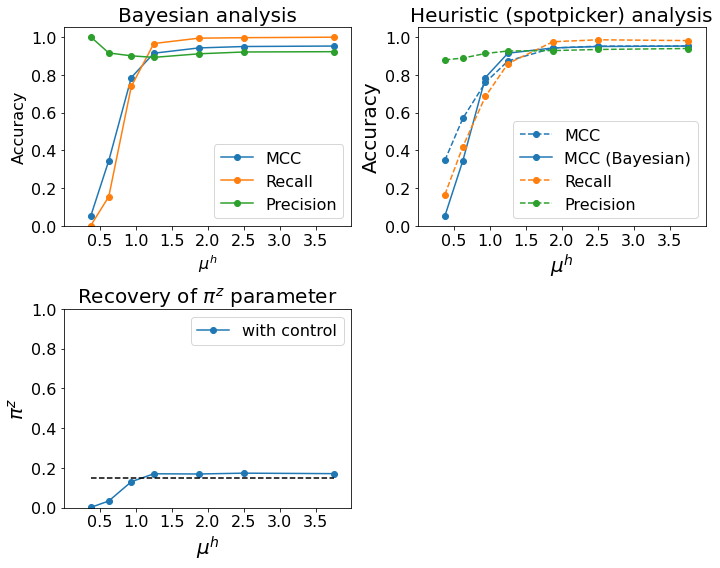

In [70]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")
#plt.plot(snr, fnr, "o-", label="FNR")
#plt.plot(snr, fpr, "o-", label="FPR")
plt.ylim(0,1.05)
plt.xlim(0,4)
plt.xlabel(r"$\mu^h$", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,8)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
#plt.plot(snr, fnr, "o-", label="FNR")
#plt.plot(snr, fpr, "o-", label="FPR")
plt.ylim(0,1.05)
plt.xlim(0,4)
plt.xlabel(r"$\mu^h$", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,8)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.subplot(223)
plt.plot(snr, scores_v1p13["pi_1"], "o-", label="with control")
plt.plot([snr[0], snr[-1]], [float(pi_z)/100, float(pi_z)/100], "--", c="k")
plt.ylim(0,1)
plt.xlim(0,4)
plt.xlabel(r"$\mu^h$", fontsize=20)
plt.ylabel(r"$\pi^z$", fontsize=20)
plt.title(r"Recovery of $\pi^z$ parameter", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,8)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

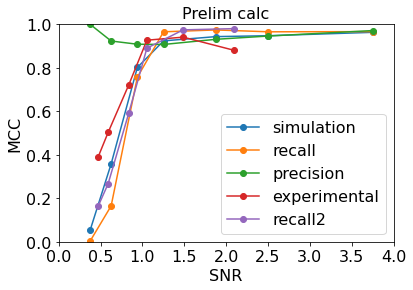

In [41]:
snr2 = np.array([0.63, 0.79, 1.12, 1.41, 1.99, 2.81]) * 2.1 / 2.81
snr3 = np.array([0.63, 0.79, 1.12, 1.41, 1.99, 2.81])
mcc2 = np.array([0.38985816, 0.50288344, 0.721728  , 0.9271966 , 0.94118549,
       0.88025585])
recall2 = np.array([0.1633888 , 0.26680527, 0.59170013, 0.89061763, 0.97470238,
       0.98042169])

plt.plot(snr, scores_v1p13["MCC"], "o-", label="simulation")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="precision")
plt.plot(snr2, mcc2, "o-", label="experimental")
plt.plot(snr2, recall2, "o-", label="recall2")
plt.title("Prelim calc", fontsize=16)
plt.xlabel("SNR", fontsize=16)
plt.ylabel("MCC", fontsize=16)
plt.xlim(0, 4)
plt.ylim(0, 1)

plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

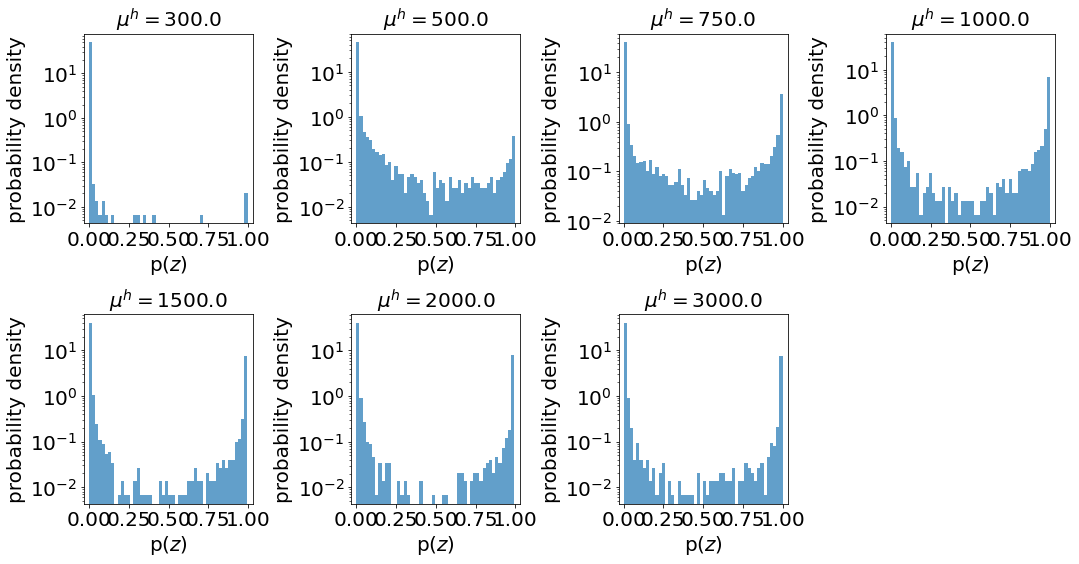

In [26]:
plt.figure(figsize=(15,15))
for i, h in enumerate(heights):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[h]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  import sys


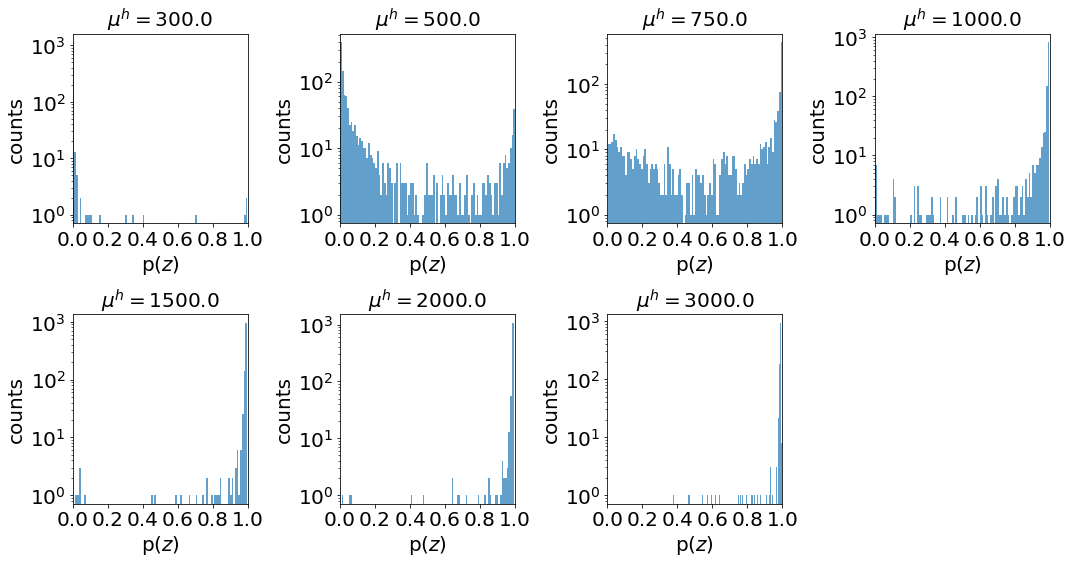

In [27]:
plt.figure(figsize=(15,15))
for i, h in enumerate(heights):
    plt.subplot(4, 4, i+1)
    mask = true_labels[h]["z"]
    plt.hist(predictions[h]["z_prob"][mask], bins=100, alpha=0.7)
    plt.xlim(0, 1)
    plt.yscale('log', nonposy='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"counts", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

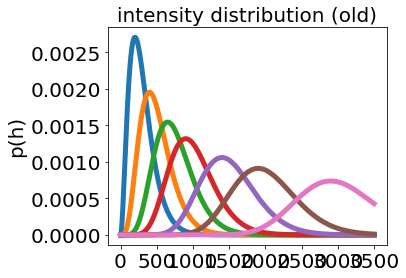

In [28]:
x = torch.arange(0,3500.,0.1)

plt.figure(figsize=(5,4))
for h in heights:
    d = dist.Gamma(float(h) * 0.01, 0.01)
    plt.plot(x, torch.exp(d.log_prob(x)).cpu(), lw=5)
#plt.plot(x, torch.exp(d2.log_prob(x)).cpu(), color="C1", lw=5)

#plt.gca().axes.get_xaxis().set_ticks([100])
#plt.gca().axes.get_yaxis().set_ticks([])
#plt.xticks(size=30)
plt.title("intensity distribution (old)", fontsize=20)
plt.ylabel("p(h)", fontsize=20)
#plt.ylim(0, 0.003)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [17]:
from cosmos.models import Tracker

In [102]:
name = "h3000pi15lamda15"
path_data = "/shared/centaur/data/height_data/{}".format(name)
path_params = "/shared/centaur/data/height_data/{}/runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5".format(name)

In [103]:
model = Tracker(S=1)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

In [111]:
spot = model.data_loc(
    torch.ones(1),
    pyro.param("d/w_mode").data[0],
    pyro.param("d/x_mode").data[0],
    pyro.param("d/y_mode").data[0],
    torch.arange(model.data.N)[:, None],
    torch.arange(model.data.F))

In [112]:
signal = model.data.data * spot
# signal = spot ** 2 / pyro.param("d/h_loc").data[0, :, :, None, None]
signal = signal.sum(dim=(-2,-1))

In [113]:
noise = (pyro.param("d/b_loc").data * pyro.param("gain").item()).sqrt()
noise.mean()

tensor(32.8759)

In [118]:
mask = pyro.param("d/theta_probs")[..., 1] > 0.5
snr = (signal - pyro.param("d/b_loc").data - 89.5) / noise
# snr = signal / noise

In [119]:
height = pyro.param("d/h_loc")[0].data[mask]
width = pyro.param("d/w_mode")[0].data[mask]
x = pyro.param("d/x_mode")[0].data[mask]
y = pyro.param("d/y_mode")[0].data[mask]
snr = snr[mask]

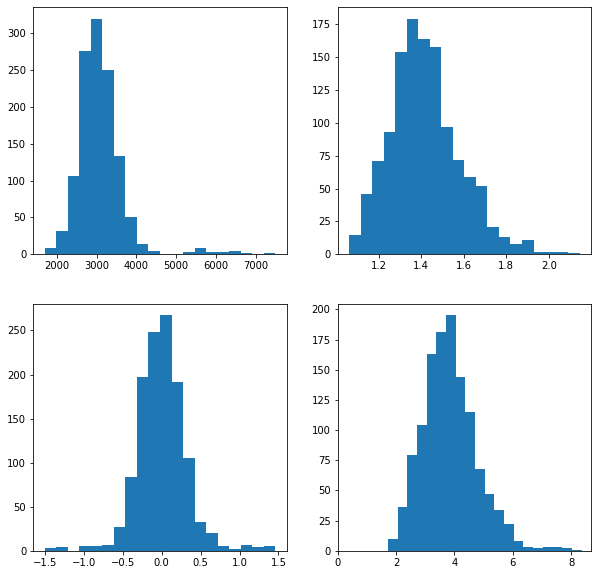

In [122]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.hist(height.numpy(), bins=20)

plt.subplot(222)
plt.hist(width.numpy(), bins=20)

plt.subplot(223)
plt.hist(x.numpy(), bins=20)

plt.subplot(224)
plt.hist(snr.numpy(), bins=20)
plt.xlim(0,)
plt.show()

In [121]:
snr.mean()

tensor(3.8446)

In [101]:
snr.mean()

tensor(3.8134)